In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import argparse
import re
import glob
import matplotlib



In [23]:
data = pd.read_csv('各產業日最大值_新增特徵後.csv')


In [24]:
# Basic Data Exploration
# Checking for missing values
missing_values = data.isnull().sum()

# Checking the distribution of numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64'])
numerical_distribution = numerical_features.describe()

# Checking for categorical features and their unique values
categorical_features = data.select_dtypes(include=['object'])
unique_values = categorical_features.nunique()

missing_values, numerical_distribution, unique_values



(date            0
 season          0
 holiday         0
 max_temp        0
 min_temp        0
 mean_temp       0
 Max_SthPres     0
 Min_StnPres     0
 Min_RH          0
 Mean_StnPres    0
 Mean_RH         0
 Mean_Precp      0
 Mean_WD         0
 Mean_WDGust     0
 Mean_WS         0
 Mean_WSGust     0
 石化業該日最高用電量      0
 金屬製造該日最高用電量     0
 資訊電子該日最高用電量     0
 綜合服務該日最高用電量     0
 民生工業該日最高用電量     0
 dtype: int64,
             season      holiday     max_temp     min_temp    mean_temp  \
 count  1642.000000  1642.000000  1642.000000  1642.000000  1642.000000   
 mean      2.450670     0.284409    30.429963    18.685597    23.640506   
 std       1.150075     0.451270     4.252950     4.881496     4.763086   
 min       0.000000     0.000000     0.000000     0.000000     0.000000   
 25%       1.000000     0.000000    27.600000    14.800000    19.872292   
 50%       2.000000     0.000000    30.800000    19.100000    24.062656   
 75%       4.000000     1.000000    34.000000    23.400000   

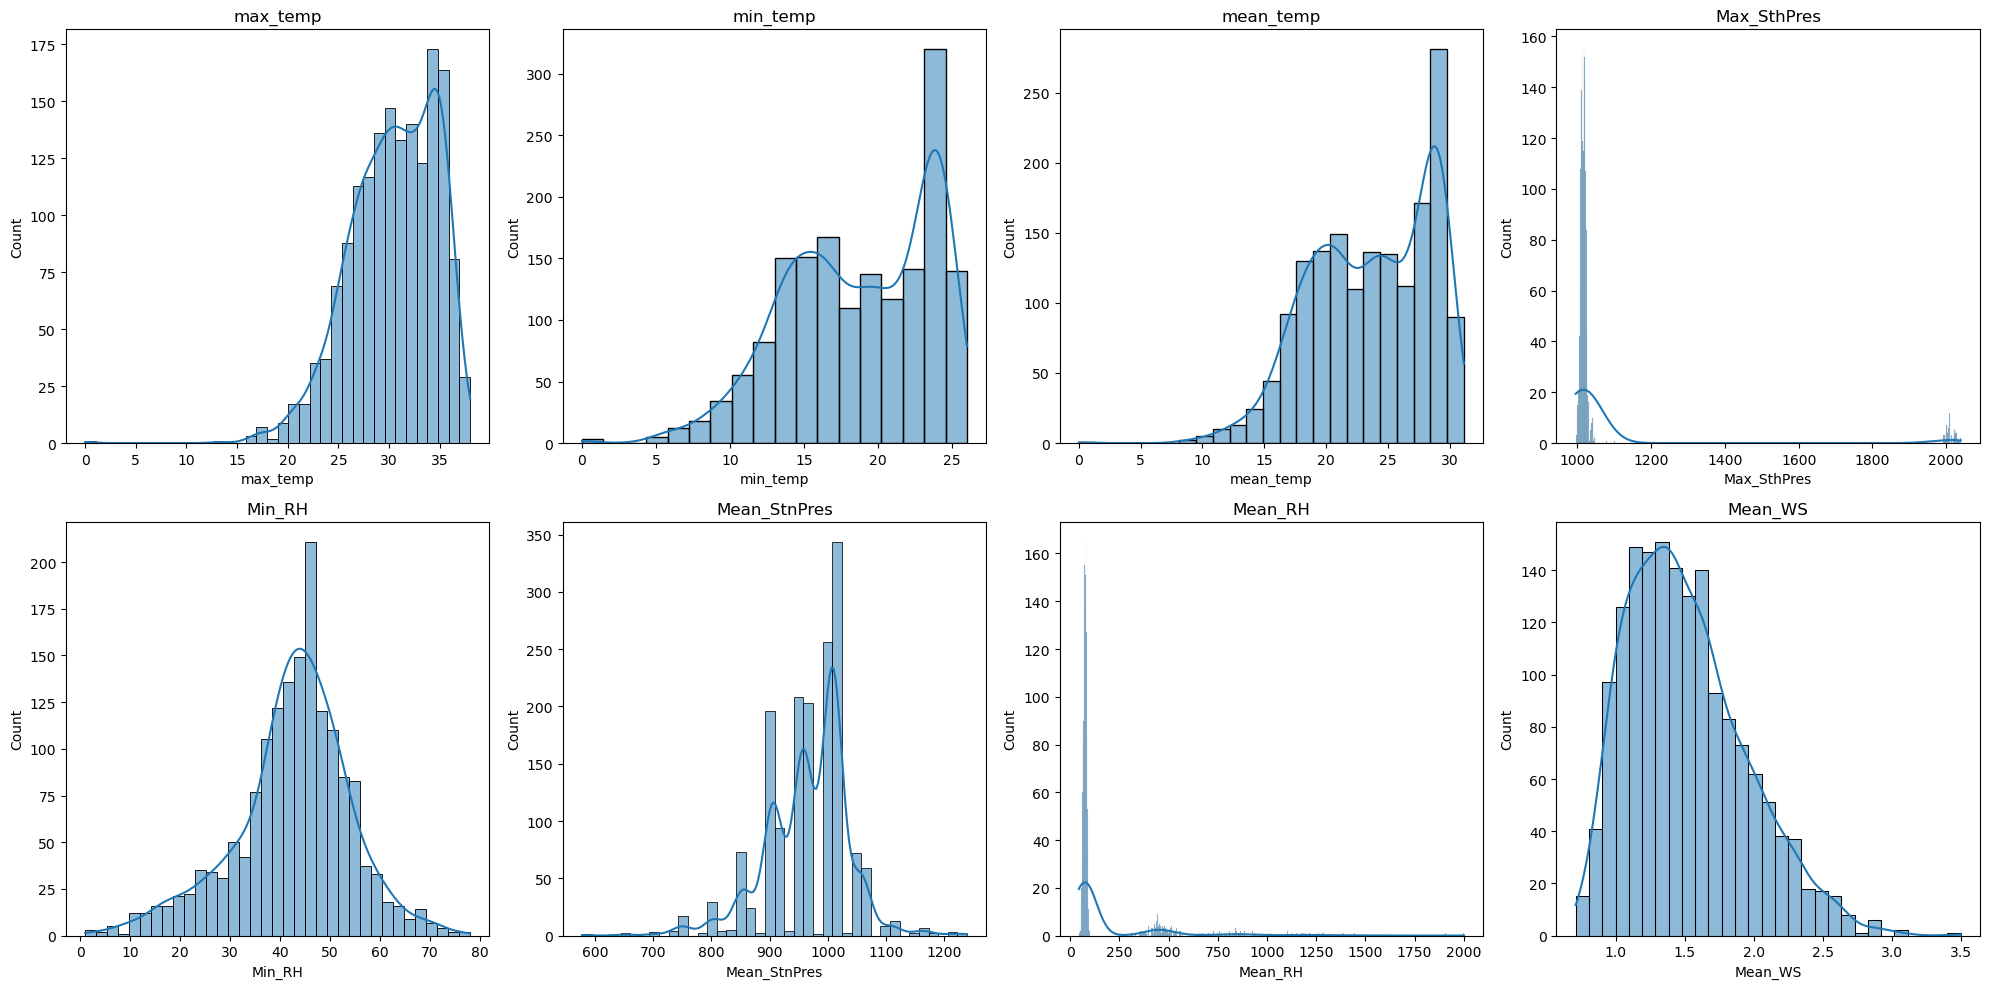

In [25]:
# Selecting the specific features for which we want to plot histograms
selected_features = ['max_temp', 'min_temp', 'mean_temp', 'Max_SthPres', 'Min_RH', 'Mean_StnPres', 'Mean_RH', 'Mean_WS']

# Setting up the plotting area
plt.figure(figsize=(20, 10))

# Plotting histograms for each selected feature
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data[feature], kde=True)
    plt.title(feature)

plt.tight_layout()
plt.show()



處理異常值，將 Max_SthPres 和 Mean_RH做 percentile capping


In [26]:
# Checking the percentile distribution for 'Max_SthPres' and 'Mean_RH'
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
percentile_distribution = data[['Max_SthPres', 'Mean_RH']].describe(percentiles=percentiles)

percentile_distribution



,Max_SthPres,Mean_RH
count,1642.000000,1642.000000
mean,1070.261389,176.870561
std,225.785129,257.383941
min,995.200000,43.684211
25%,1011.200000,70.584211
50%,1016.800000,77.250000
75%,1021.600000,85.087500
90%,1027.100000,474.615000
95%,1995.960000,787.510000
99%,2026.436000,1293.251500


In [27]:
import numpy as np


In [28]:
# Applying percentile capping to 'Max_SthPres' and 'Mean_RH' at the 99th percentile
for col in ['Max_SthPres', 'Mean_RH']:
    percentile_99 = data[col].quantile(0.99)
    data[col] = np.where(data[col] > percentile_99, percentile_99, data[col])

# Checking the new distribution after percentile capping
new_percentile_distribution = data[['Max_SthPres', 'Mean_RH']].describe(percentiles=percentiles)

new_percentile_distribution



,Max_SthPres,Mean_RH
count,1642.000000,1642.000000
mean,1070.212797,174.735937
std,225.578210,246.209939
min,995.200000,43.684211
25%,1011.200000,70.584211
50%,1016.800000,77.250000
75%,1021.600000,85.087500
90%,1027.100000,474.615000
95%,1995.960000,787.510000
99%,2026.339240,1290.626885


对 Mean_WS 做對數轉換



In [29]:
# Importing numpy
import numpy as np

# Applying log transformation to 'Mean_WS'
# Adding 1 to avoid log(0) which is undefined
data['Mean_WS_log'] = np.log1p(data['Mean_WS'])

# Checking the first few rows to verify the transformation
data[['Mean_WS', 'Mean_WS_log']].head()



,Mean_WS,Mean_WS_log
0,2.135000,1.142629
1,1.495000,0.914289
2,1.384211,0.868868
3,1.305000,0.835081
4,1.955000,1.083499


特征缩放：我们对所有数值特征应用了 MinMaxScaler 进行归一化。


In [30]:
# Applying MinMaxScaler to all numerical features
from sklearn.preprocessing import MinMaxScaler

# Selecting numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

# Initializing the MinMaxScaler
min_max_scaler = MinMaxScaler()

# Applying the scaler to the numerical features
data[numerical_features] = min_max_scaler.fit_transform(data[numerical_features])

# Checking the first few rows after scaling
data[numerical_features].head()



,season,holiday,max_temp,min_temp,mean_temp,Max_SthPres,Min_StnPres,Min_RH,Mean_StnPres,Mean_RH,...,Mean_WD,Mean_WDGust,Mean_WS,Mean_WSGust,石化業該日最高用電量,金屬製造該日最高用電量,資訊電子該日最高用電量,綜合服務該日最高用電量,民生工業該日最高用電量,Mean_WS_log
0,1.0,0.0,0.673684,0.503846,0.557857,0.027637,0.998196,0.545455,0.660376,0.024141,...,0.002025,0.001147,0.511670,0.429940,0.622311,0.456662,0.584242,0.060494,0.477941,0.627163
1,1.0,0.0,0.671053,0.465385,0.609071,0.028413,0.998050,0.532468,0.582111,0.024381,...,0.002445,0.001844,0.281867,0.251008,0.789035,0.536662,0.640956,0.074545,0.836889,0.390901
2,1.0,0.0,0.673684,0.523077,0.629022,0.024825,0.998074,0.610390,0.578102,0.301957,...,0.010433,0.007661,0.242086,0.198721,0.804558,0.557253,0.632406,0.075817,0.875184,0.343905
3,1.0,0.0,0.642105,0.576923,0.607415,0.023176,0.997855,0.649351,0.655563,0.035065,...,0.004373,0.001627,0.213645,0.380544,0.820313,0.539131,0.635813,0.076252,0.873371,0.308946
4,1.0,0.0,0.631579,0.553846,0.565569,0.022885,0.997514,0.935065,0.654731,0.037666,...,0.001304,0.000697,0.447038,0.447581,0.809138,0.577511,0.629515,0.075532,0.873817,0.565981


In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 假设 'data' 是您已经预处理的Pandas DataFrame
# 包含了用于模型的特征和目标变量

# 选择模型特征
features = ['season', 'holiday', 'max_temp', 'min_temp', 'mean_temp', 'Max_SthPres', 'Min_RH', 'Mean_StnPres', 'Mean_RH', 'Mean_WS_log']

# 选择模型目标
targets = ['石化業該日最高用電量', '金屬製造該日最高用電量', '資訊電子該日最高用電量', '綜合服務該日最高用電量', '民生工業該日最高用電量']


X = data[features]
y = data[targets]

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化模型
model = LinearRegression()
model.fit(X_train, y_train)

#预测    
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): [0.00400395 0.00418824 0.00490997 0.00070151 0.01061245]
Mean Absolute Error (MAE): [0.04192839 0.03981967 0.05679945 0.00679182 0.06548432]


In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 初始化模型
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# 存儲每個模型的性能
performance = {target: {} for target in targets}
# 對於每個目標變量，訓練並評估每個模型
for target in targets:
    y_train_target = y_train[target]
    y_test_target = y_test[target]
    for name, model in models.items():
        model.fit(X_train, y_train_target)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test_target, y_pred)
        mae = mean_absolute_error(y_test_target, y_pred)
        performance[target][name] = {"MSE": mse, "MAE": mae}

# 印每個模型的性能
for target, models_performance in performance.items():
    print(f"Target: {target}")
    for model_name, metrics in models_performance.items():
        print(f"    {model_name} - MSE: {metrics['MSE']}, MAE: {metrics['MAE']}")


Target: 石化業該日最高用電量
    Linear Regression - MSE: 0.0040039505809930645, MAE: 0.041928392905483405
    Decision Tree - MSE: 0.007371851046623915, MAE: 0.05495562178099301
    Random Forest - MSE: 0.004100835367903004, MAE: 0.041604382552649824
    SVR - MSE: 0.004747900931960156, MAE: 0.052774504617391874
    Gradient Boosting - MSE: 0.0041326209780749345, MAE: 0.04152204051074236
    K-Nearest Neighbors - MSE: 0.004325121933312889, MAE: 0.04274349033423709
Target: 金屬製造該日最高用電量
    Linear Regression - MSE: 0.004188238660436155, MAE: 0.039819666829908895
    Decision Tree - MSE: 0.005971432918481305, MAE: 0.05124783284689628
    Random Forest - MSE: 0.004343969102219322, MAE: 0.041282166593682376
    SVR - MSE: 0.005302722810908169, MAE: 0.05097391598035526
    Gradient Boosting - MSE: 0.004222407762434794, MAE: 0.04041312378403343
    K-Nearest Neighbors - MSE: 0.0047325555018201335, MAE: 0.04228828723054981
Target: 資訊電子該日最高用電量
    Linear Regression - MSE: 0.004909972438314131, MAE: 0.056